# Exploratory Data Analysis
---

In [12]:
import os
import duckdb

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


In [2]:
credit_df = pd.read_csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz")

/tmp/ipykernel_47/4129410347.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  credit_df = pd.read_csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz")


### Missing Values

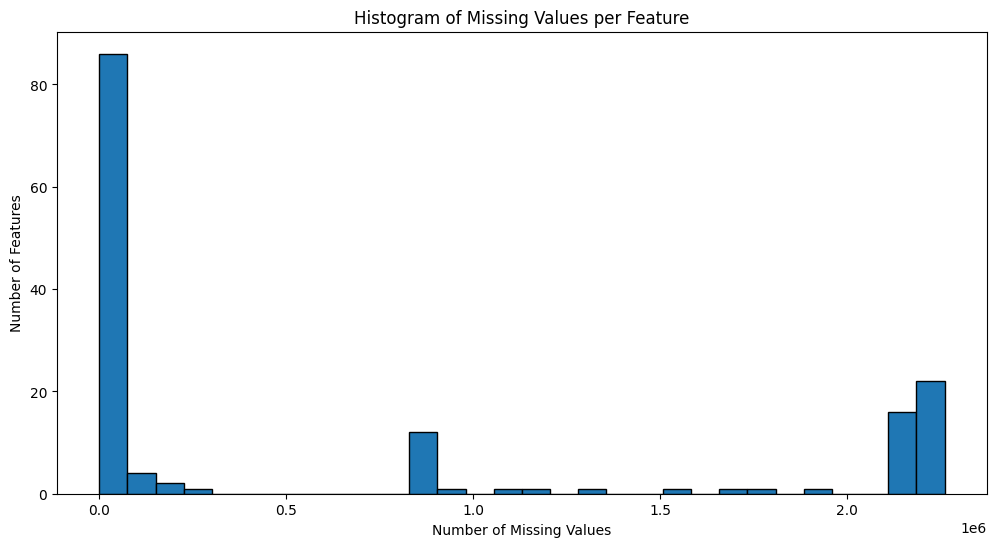

---

### Data Types

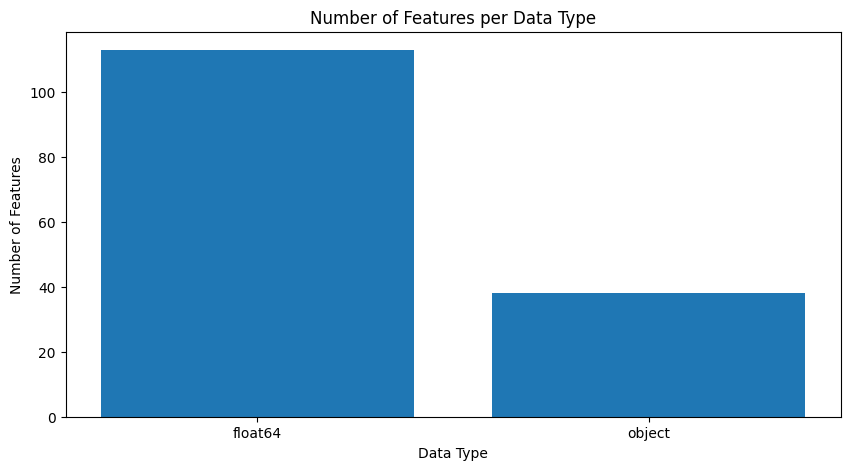

---

In [42]:
def Explore(df, show_missing=False ,show_dtypes=False, show_unique_count=False, show_shape=False):
    if show_missing:
        # Display count of all missing values in each column
        display(Markdown("### Missing Values"))
        
        # Sum of missing values in each column and convertion to a dataframe.
        missing_values = df.isnull().sum()

        # histogram
        plt.figure(figsize=(12, 6))
        plt.hist(missing_values.values, bins=30, edgecolor='black')  # adjust bins as needed
        plt.xlabel("Number of Missing Values")
        plt.ylabel("Number of Features")
        plt.title("Histogram of Missing Values per Feature")
        plt.show()
        display(Markdown("---"))    

    if show_dtypes:
        # Display data types
        display(Markdown("### Data Types"))

        # Identify data types
        data_types = df.dtypes
        
        # Count number of features per dtype
        dtype_counts = data_types.value_counts()

        # Barchart
        plt.figure(figsize=(10, 5))
        plt.bar(dtype_counts.index.astype(str), dtype_counts.values)
        plt.xlabel("Data Type")
        plt.ylabel("Number of Features")
        plt.title("Number of Features per Data Type")
        plt.show()        
        display(Markdown("---"))    

    if show_unique_count:
        # Display Unique Values Count
        display(Markdown("### Number of Unique Values"))
        
        # Display count of all missing values in each column
        number_of_unique_values = df.nunique()
        number_of_unique_values_paired = list(zip(number_of_unique_values.index.tolist(), number_of_unique_values.values.tolist()))
        display(number_of_unique_values_paired)
        display(Markdown("---"))        

    if show_shape:
        display(Markdown("### Shape"))
        display(df.shape)
        display(Markdown("---"))

Explore(credit_df, show_missing=True ,show_dtypes=True, show_unique_count=False, show_shape=False)

### **Ideal Columns For Credit Risk Modelling in Real Time**
#### **Credit Risk Fundamentals**
- fico_range_low
- fico_range_high
- dti
- revol_util
- annual_inc
#### **Delinquency History** 
- delinq_2yrs
- pub_rec_bankruptcies
- inq_last_6mths
#### Loan Characteristics 
- loan_amnt
- int_rate
- term
#### Credit Profile 
- total_acc
- open_acc
- credit_age_month (engineered from earliest_cr_line)
#### Categorical 
- home_ownership
- purpose
- emp_length
- addr_state
- verification_status
#### Label
- loan_status


### **Insights From Analyzing Credit Data and How Credit Operates**
- Most of the other columns are generated behind the scenes by sending API calls to Credit Bureaus, which are companies that collect finanancial data on individuals and businesses in terms of loans, credit cards, payment hinstory, defaults, bankruptcies etc. e.g. TransUnion, Experian and Equifax.
- To create a real time system using streamlit I'll only be using relevant features that are applicable in real time such the detailed above.

In [39]:
credit_df['id'].map(type).value_counts()

id
<class 'int'>    2195456
<class 'str'>      65245
Name: count, dtype: int64

### Missing Values

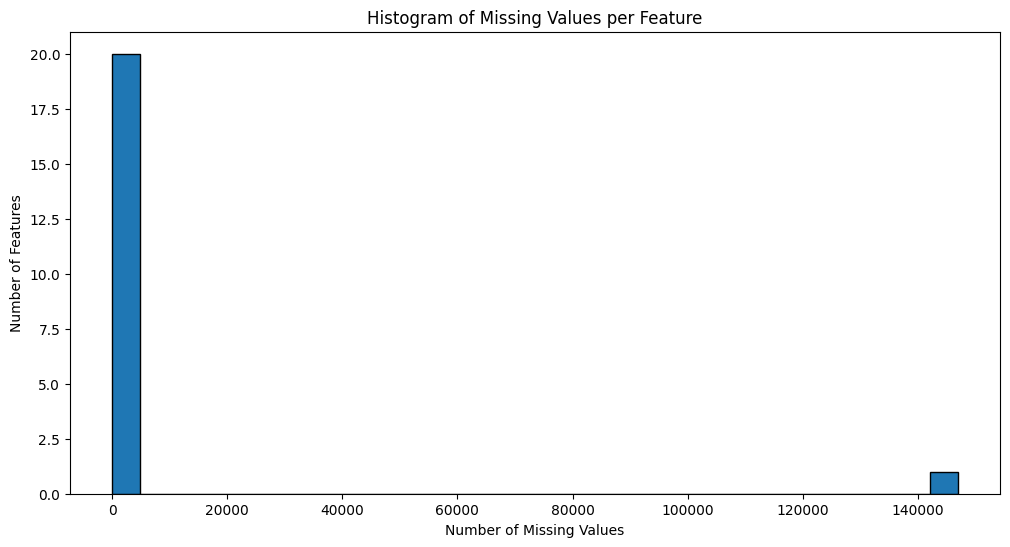

---

### Data Types

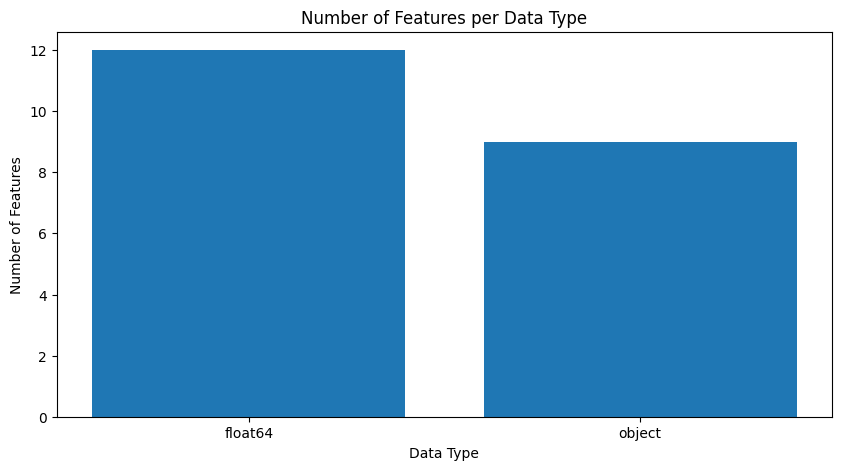

---

In [55]:
# Filter to only have relevant columns for further modelling
cols = ['fico_range_low', 'fico_range_high', 'dti', 'revol_util', 'annual_inc', 'delinq_2yrs', 'pub_rec_bankruptcies', 
        'inq_last_6mths', 'loan_amnt','int_rate', 'term', 'total_acc', 'open_acc', 'earliest_cr_line', 'home_ownership', 
        'purpose', 'emp_length', 'addr_state', 'verification_status','loan_status', 'issue_d']

relevant_credit_df = credit_df[cols]
Explore(relevant_credit_df, show_missing=True ,show_dtypes=True, show_unique_count=False, show_shape=False)

# Feature Engineering
---
### Row-Level Transformations Only

In [69]:
# Convert earliest_cr_line and issue_d to datetime to extract months in between
relevant_credit_df['earliest_cr_line'] = pd.to_datetime(
    relevant_credit_df['earliest_cr_line'])
relevant_credit_df['issue_d'] = pd.to_datetime(
    relevant_credit_df['issue_d'])

# Calculate the months inbetween the date the loan was issued and the first time the user got credit
relevant_credit_df['credible_month'] = (
    (relevant_credit_df['issue_d'].dt.year - relevant_credit_df['earliest_cr_line'].dt.year) * 12 + 
    (relevant_credit_df['issue_d'].dt.month - relevant_credit_df['earliest_cr_line'].dt.month)
)

# Drop earliest_cr_line and issue_d
relevant_credit_df = relevant_credit_df.drop(columns=['earliest_cr_line', 'issue_d'])

relevant_credit_df['credible_month'].head()

/tmp/ipykernel_47/688607558.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  relevant_credit_df['earliest_cr_line'] = pd.to_datetime(
/tmp/ipykernel_47/688607558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_credit_df['earliest_cr_line'] = pd.to_datetime(
/tmp/ipykernel_47/688607558.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  relevant_credit_df['issue_d'] = pd.to_datetime(
/tmp/ipykernel_47/688607558.py:4: SettingWithCopyWarning: 
A value is tryi

0    148.0
1    192.0
2    184.0
3     87.0
4    210.0
Name: credible_month, dtype: float64

In [70]:
relevant_credit_df['income_to_loan_ratio'] = relevant_credit_df['annual_inc'] / relevant_credit_df['loan_amnt']
relevant_credit_df['income_to_loan_ratio'].head()

0    15.277778
1     2.631579
2     3.150000
3     3.142857
4    10.041635
Name: income_to_loan_ratio, dtype: float64

In [71]:
relevant_credit_df['fico_avg'] = (relevant_credit_df['fico_range_low'] + relevant_credit_df['fico_range_high']) /2
relevant_credit_df['fico_avg'].head()

0    677.0
1    717.0
2    697.0
3    787.0
4    697.0
Name: fico_avg, dtype: float64

### Target Encoding

In [57]:
# Example: your loan status series
loan_status = pd.Series([
    'Fully Paid', 'Current', 'Charged Off', 'Late (31-120 days)',
    'In Grace Period', 'Late (16-30 days)',
    'Does not meet the credit policy. Status:Fully Paid',
    'Does not meet the credit policy. Status:Charged Off',
    'Default'
])

# Mapping to binary target
default_mapping = {
    'Charged Off': 1,
    'Default': 1,
    'Late (31-120 days)': 1,
    'Late (16-30 days)': 1,
    'Does not meet the credit policy. Status:Charged Off': 1,
    'Fully Paid': 0,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    'Current': 0,              # include cautiously
    'In Grace Period': 0       # treat cautiously
}

relevant_credit_df.loc[:, 'loan_status_binary'] = relevant_credit_df['loan_status'].map(default_mapping)
relevant_credit_df['loan_status_binary'].isnull().sum()


33

# Removing Data Quality Issues (Before Split)
---

In [58]:
# Assess how many rows are missing values across the selected 20 columns
# Count missing values accross columns, filter out those with no missing values and sort in descending order
null_count_per_row = relevant_credit_df.isnull().sum(axis=1)
null_count_per_row = null_count_per_row[null_count_per_row > 0]
null_count_per_row = null_count_per_row.sort_values(ascending=False)
display(null_count_per_row.value_counts())

1     148228
2       1744
22        33
7         25
8          4
3          4
Name: count, dtype: int64

### Missing Values

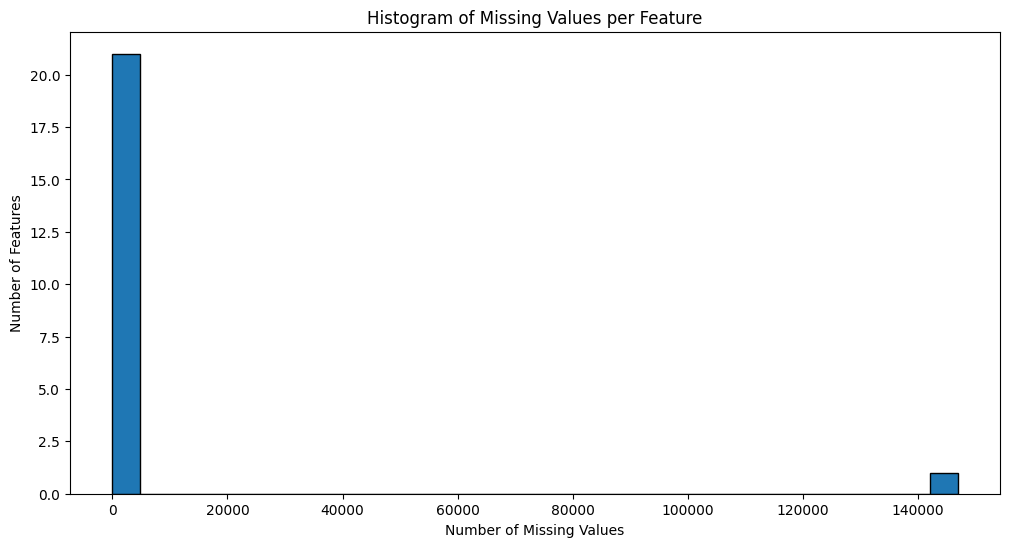

---

In [60]:
# Drop all rows with 20 missing values, essentially corrupt rows with no useable data
relevant_credit_df = relevant_credit_df.dropna(how='all')

# Re-examine data
Explore(relevant_credit_df, show_missing=True ,show_dtypes=False, show_unique_count=False, show_shape=False)

# Train-Val-Test Split 
---

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
X = relevant_credit_df.drop(columns=['loan_status', 'loan_status_binary'])
y = relevant_credit_df['loan_status_binary']

print(X.shape)
print(y.shape)

(2260668, 20)
(2260668,)


In [65]:
train_df, temp_df = train_test_split(X, test_size=0.2, random_state=42)
val_df, test_df   = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train df shape: {train_df.shape}")
print(f"Train df shape: {val_df.shape}")
print(f"Train df shape: {test_df.shape}")

Train df shape: (1808534, 20)
Train df shape: (226067, 20)
Train df shape: (226067, 20)


# Imputation (After Data Splitting)
---

In [76]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [77]:
# Separate numeric and categorical values for imputation
numeric_cols = ['revol_util' ,'dti', 'pub_rec_bankruptcies', 'inq_last_6mths', 'delinq_2yrs', 'total_acc', 'open_acc', 'annual_inc', 'credible_month', 'income_to_loan_ratio']
categorical_cols = ['emp_length']

# Create imputers
numeric_imputer = SimpleImputer(strategy="median")
categorical_imputer = SimpleImputer(strategy="most_frequent")

# Combine into 1 preprocessing step
preproces_imputation = ColumnTransformer(
    transformers =[
        ("num_cols", numeric_imputer, numeric_cols),
        ("cat_cols", categorical_imputer, categorical_cols)
    ],
    remainder="passthrough"
)

# Fit only on training data
preproces_imputation.fit(train_df)

# transform on all data
train_df_clean = preproces_imputation.transform(train_df)
val_df_clean   = preproces_imputation.transform(val_df)
test_df_clean  = preproces_imputation.transform(test_df)

# --- FIX: convert back to DataFrames ---
output_cols = preproces_imputation.get_feature_names_out()

train_df_clean = pd.DataFrame(train_df_clean, columns=output_cols)
val_df_clean   = pd.DataFrame(val_df_clean, columns=output_cols)
test_df_clean  = pd.DataFrame(test_df_clean, columns=output_cols)

# Now Explore() works
Explore(train_df_clean)
Explore(val_df_clean)
Explore(test_df_clean)


### Missing Values

[('num_cols__revol_util', 0),
 ('num_cols__dti', 0),
 ('remainder__loan_status', 0),
 ('remainder__verification_status', 0),
 ('remainder__addr_state', 0),
 ('remainder__purpose', 0),
 ('remainder__home_ownership', 0),
 ('remainder__term', 0),
 ('remainder__int_rate', 0),
 ('remainder__loan_amnt', 0),
 ('remainder__fico_range_high', 0),
 ('remainder__fico_range_low', 0),
 ('cat_cols__emp_length', 0),
 ('num_cols__income_to_loan_ratio', 0),
 ('num_cols__credible_month', 0),
 ('num_cols__annual_inc', 0),
 ('num_cols__open_acc', 0),
 ('num_cols__total_acc', 0),
 ('num_cols__delinq_2yrs', 0),
 ('num_cols__inq_last_6mths', 0),
 ('num_cols__pub_rec_bankruptcies', 0),
 ('remainder__fico_avg', 0)]

---

### Data Types

[('num_cols__revol_util', dtype('O')),
 ('num_cols__dti', dtype('O')),
 ('num_cols__pub_rec_bankruptcies', dtype('O')),
 ('num_cols__inq_last_6mths', dtype('O')),
 ('num_cols__delinq_2yrs', dtype('O')),
 ('num_cols__total_acc', dtype('O')),
 ('num_cols__open_acc', dtype('O')),
 ('num_cols__annual_inc', dtype('O')),
 ('num_cols__credible_month', dtype('O')),
 ('num_cols__income_to_loan_ratio', dtype('O')),
 ('cat_cols__emp_length', dtype('O')),
 ('remainder__fico_range_low', dtype('O')),
 ('remainder__fico_range_high', dtype('O')),
 ('remainder__loan_amnt', dtype('O')),
 ('remainder__int_rate', dtype('O')),
 ('remainder__term', dtype('O')),
 ('remainder__home_ownership', dtype('O')),
 ('remainder__purpose', dtype('O')),
 ('remainder__addr_state', dtype('O')),
 ('remainder__verification_status', dtype('O')),
 ('remainder__loan_status', dtype('O')),
 ('remainder__fico_avg', dtype('O'))]

---

### Number of Unique Values

[('num_cols__revol_util', 1378),
 ('num_cols__dti', 10182),
 ('num_cols__pub_rec_bankruptcies', 11),
 ('num_cols__inq_last_6mths', 25),
 ('num_cols__delinq_2yrs', 36),
 ('num_cols__total_acc', 147),
 ('num_cols__open_acc', 90),
 ('num_cols__annual_inc', 77695),
 ('num_cols__credible_month', 770),
 ('num_cols__income_to_loan_ratio', 197035),
 ('cat_cols__emp_length', 11),
 ('remainder__fico_range_low', 47),
 ('remainder__fico_range_high', 47),
 ('remainder__loan_amnt', 1570),
 ('remainder__int_rate', 668),
 ('remainder__term', 2),
 ('remainder__home_ownership', 6),
 ('remainder__purpose', 14),
 ('remainder__addr_state', 51),
 ('remainder__verification_status', 3),
 ('remainder__loan_status', 9),
 ('remainder__fico_avg', 47)]

---

### Shape

(1808534, 22)

---

### Missing Values

[('num_cols__revol_util', 0),
 ('num_cols__dti', 0),
 ('remainder__loan_status', 0),
 ('remainder__verification_status', 0),
 ('remainder__addr_state', 0),
 ('remainder__purpose', 0),
 ('remainder__home_ownership', 0),
 ('remainder__term', 0),
 ('remainder__int_rate', 0),
 ('remainder__loan_amnt', 0),
 ('remainder__fico_range_high', 0),
 ('remainder__fico_range_low', 0),
 ('cat_cols__emp_length', 0),
 ('num_cols__income_to_loan_ratio', 0),
 ('num_cols__credible_month', 0),
 ('num_cols__annual_inc', 0),
 ('num_cols__open_acc', 0),
 ('num_cols__total_acc', 0),
 ('num_cols__delinq_2yrs', 0),
 ('num_cols__inq_last_6mths', 0),
 ('num_cols__pub_rec_bankruptcies', 0),
 ('remainder__fico_avg', 0)]

---

### Data Types

[('num_cols__revol_util', dtype('O')),
 ('num_cols__dti', dtype('O')),
 ('num_cols__pub_rec_bankruptcies', dtype('O')),
 ('num_cols__inq_last_6mths', dtype('O')),
 ('num_cols__delinq_2yrs', dtype('O')),
 ('num_cols__total_acc', dtype('O')),
 ('num_cols__open_acc', dtype('O')),
 ('num_cols__annual_inc', dtype('O')),
 ('num_cols__credible_month', dtype('O')),
 ('num_cols__income_to_loan_ratio', dtype('O')),
 ('cat_cols__emp_length', dtype('O')),
 ('remainder__fico_range_low', dtype('O')),
 ('remainder__fico_range_high', dtype('O')),
 ('remainder__loan_amnt', dtype('O')),
 ('remainder__int_rate', dtype('O')),
 ('remainder__term', dtype('O')),
 ('remainder__home_ownership', dtype('O')),
 ('remainder__purpose', dtype('O')),
 ('remainder__addr_state', dtype('O')),
 ('remainder__verification_status', dtype('O')),
 ('remainder__loan_status', dtype('O')),
 ('remainder__fico_avg', dtype('O'))]

---

### Number of Unique Values

[('num_cols__revol_util', 1134),
 ('num_cols__dti', 5813),
 ('num_cols__pub_rec_bankruptcies', 9),
 ('num_cols__inq_last_6mths', 16),
 ('num_cols__delinq_2yrs', 25),
 ('num_cols__total_acc', 123),
 ('num_cols__open_acc', 66),
 ('num_cols__annual_inc', 17063),
 ('num_cols__credible_month', 683),
 ('num_cols__income_to_loan_ratio', 41048),
 ('cat_cols__emp_length', 11),
 ('remainder__fico_range_low', 44),
 ('remainder__fico_range_high', 44),
 ('remainder__loan_amnt', 1517),
 ('remainder__int_rate', 607),
 ('remainder__term', 2),
 ('remainder__home_ownership', 6),
 ('remainder__purpose', 14),
 ('remainder__addr_state', 51),
 ('remainder__verification_status', 3),
 ('remainder__loan_status', 9),
 ('remainder__fico_avg', 44)]

---

### Shape

(226067, 22)

---

### Missing Values

[('num_cols__revol_util', 0),
 ('num_cols__dti', 0),
 ('remainder__loan_status', 0),
 ('remainder__verification_status', 0),
 ('remainder__addr_state', 0),
 ('remainder__purpose', 0),
 ('remainder__home_ownership', 0),
 ('remainder__term', 0),
 ('remainder__int_rate', 0),
 ('remainder__loan_amnt', 0),
 ('remainder__fico_range_high', 0),
 ('remainder__fico_range_low', 0),
 ('cat_cols__emp_length', 0),
 ('num_cols__income_to_loan_ratio', 0),
 ('num_cols__credible_month', 0),
 ('num_cols__annual_inc', 0),
 ('num_cols__open_acc', 0),
 ('num_cols__total_acc', 0),
 ('num_cols__delinq_2yrs', 0),
 ('num_cols__inq_last_6mths', 0),
 ('num_cols__pub_rec_bankruptcies', 0),
 ('remainder__fico_avg', 0)]

---

### Data Types

[('num_cols__revol_util', dtype('O')),
 ('num_cols__dti', dtype('O')),
 ('num_cols__pub_rec_bankruptcies', dtype('O')),
 ('num_cols__inq_last_6mths', dtype('O')),
 ('num_cols__delinq_2yrs', dtype('O')),
 ('num_cols__total_acc', dtype('O')),
 ('num_cols__open_acc', dtype('O')),
 ('num_cols__annual_inc', dtype('O')),
 ('num_cols__credible_month', dtype('O')),
 ('num_cols__income_to_loan_ratio', dtype('O')),
 ('cat_cols__emp_length', dtype('O')),
 ('remainder__fico_range_low', dtype('O')),
 ('remainder__fico_range_high', dtype('O')),
 ('remainder__loan_amnt', dtype('O')),
 ('remainder__int_rate', dtype('O')),
 ('remainder__term', dtype('O')),
 ('remainder__home_ownership', dtype('O')),
 ('remainder__purpose', dtype('O')),
 ('remainder__addr_state', dtype('O')),
 ('remainder__verification_status', dtype('O')),
 ('remainder__loan_status', dtype('O')),
 ('remainder__fico_avg', dtype('O'))]

---

### Number of Unique Values

[('num_cols__revol_util', 1125),
 ('num_cols__dti', 5889),
 ('num_cols__pub_rec_bankruptcies', 9),
 ('num_cols__inq_last_6mths', 17),
 ('num_cols__delinq_2yrs', 21),
 ('num_cols__total_acc', 115),
 ('num_cols__open_acc', 65),
 ('num_cols__annual_inc', 16948),
 ('num_cols__credible_month', 674),
 ('num_cols__income_to_loan_ratio', 40906),
 ('cat_cols__emp_length', 11),
 ('remainder__fico_range_low', 43),
 ('remainder__fico_range_high', 43),
 ('remainder__loan_amnt', 1518),
 ('remainder__int_rate', 605),
 ('remainder__term', 2),
 ('remainder__home_ownership', 6),
 ('remainder__purpose', 14),
 ('remainder__addr_state', 51),
 ('remainder__verification_status', 3),
 ('remainder__loan_status', 9),
 ('remainder__fico_avg', 43)]

---

### Shape

(226067, 22)

---